# UBC OCEAN Classifier - Fastai Training - 5 Random Tiles 1024px, convnext .04 learning rate

* This notebook trains a fastai classifier on the generated dataset with the following parameters
    * Has 5 1024 pixel random crops for each image. 
    * TMA Scaling
    * Quality metric has improved percentage that processed. 
        * all thumbnail images are resized to 224 x 224 to use the vit pretrained model
        * arch = 'convnext_tiny_in22k'
        * learning rate = .04
<br><br>
* Paths from here
    * Adjust learning rates
    * Change architectures
    * 512 model with 20x
    * 256 model with 80x
    * Other combos
    * Then avg blends, optimize weights
    


# Installs

In [1]:
# For IEEE style plotting
!pip install /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl

Processing /kaggle/input/scienceplots-2-1-0/SciencePlots-2.1.0-py3-none-any.whl


In [2]:
!ls /kaggle/input/pyvips-python-and-deb-package

!dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package/linux_packages/archives/*.deb

!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package/python_packages/ --no-index
!pip list | grep pyvips


linux_packages	python_packages
Selecting previously unselected package autoconf.
(Reading database ... 107763 files and directories currently installed.)
Preparing to unpack .../autoconf_2.69-11.1_all.deb ...
Unpacking autoconf (2.69-11.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_1%3a1.16.1-4ubuntu6_all.deb ...
Unpacking automake (1:1.16.1-4ubuntu6) ...
Selecting previously unselected package autopoint.
Preparing to unpack .../autopoint_0.19.8.1-10build1_all.deb ...
Unpacking autopoint (0.19.8.1-10build1) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20180224.1_all.deb ...
Unpacking autotools-dev (20180224.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-2_all.deb ...
Unpacking bzip2-doc (1.0.8-2) ...
Selecting previously unselected package debhelper.
Preparing to unpack .../debhelper_12.10ubuntu1_all.deb ...
Unpacking debhelper (12.10ubuntu1

# Imports

In [3]:
import fastai
from fastai.vision.all import *
fastai.__version__

'2.7.12'

In [4]:
import os
import gc
import shutil
from glob import glob
from os import path

import cv2
import numpy as np
import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

import pyvips
pyvips.__version__

'2.2.2'

# Load Data

* There are four folders, train_images, train_thumbnails, test_images, test_thumbnails
    * There are 538 files in the train images folder, and 513 in the train_thumbnails folder
    * There is only one file in each of the test images/thumbnails folders.  It has the same label (41).
* There are three csv files, train, test, and sample_submission

Why do we have the thumbnails...to make training faster?

In [5]:
top_dir = '/kaggle/input/UBC-OCEAN'
new_train_dir = '/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled'

train = pd.read_csv(top_dir + '/train.csv')
test = pd.read_csv(top_dir + '/test.csv')
ss = pd.read_csv(top_dir + '/sample_submission.csv')

## Train/Test Csv files EDA

In [6]:
print(f'Size of training data: {train.shape}')
display(train.head())
display(test.head())

Size of training data: (538, 5)


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


,image_id,image_width,image_height
0,41,28469,16987


## Label Distribution

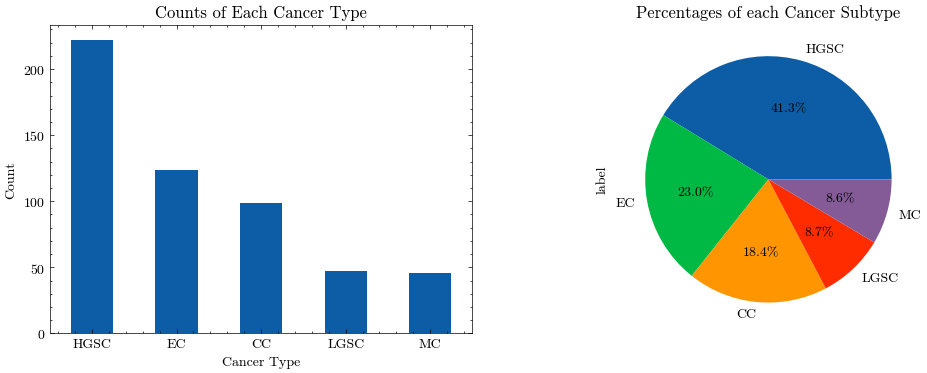

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train['label'].value_counts().plot(kind='bar', xlabel='Cancer Type', ylabel='Count', rot=0)
plt.title('Counts of Each Cancer Type')
plt.subplot(1,2,2)
train['label'].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label")
plt.title('Percentages of each Cancer Subtype');

## Add new path to images 
* With 512 pixel center tiles
* remove empty images better since implemented retries

## Make a list of files and remove empty images

In [8]:
# make a list of all files in the dataset
train_files = glob(new_train_dir + '/**/*.png',recursive=True)
train_files = [file for file in train_files if '__results' not in file]  # will fix this on the next dataset

# for file in train_files:
#     if '__results' in file:
#         os.remove(file)
        
len(train_files)


2690

In [9]:
img_ids, labels = [],[]

for file in train_files:
    img_ids.append(file.split('/')[-1].split('_')[0])
    labels.append(file.split('/')[-2])

data = list(zip(img_ids,labels,train_files))
            
new_train = pd.DataFrame(data,columns=['img_id','label','img_path'])
new_train.head()

,img_id,label,img_path
0,11557,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/11557_0.png
1,33976,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/33976_2.png
2,37385,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/37385_0.png
3,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_0.png
4,39258,LGSC,/kaggle/input/ubc-dataset-1024px-5-random-tiles-tma-scaled/new_train/LGSC/39258_2.png


<Axes: xlabel='label'>

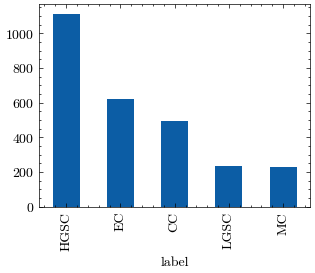

In [10]:
new_train.label.value_counts().plot(kind='bar')

# Model
* The goal is to start with Fastai and the thumbnail images
    * Then use the larger images, deal with tiling, etc.
    * First need to create a subfolder structure which loads the correct thumbnails into the correct folders

## Fastai Model Setup

In [11]:
from fastai.vision.all import *
import timm

In [12]:
from sklearn.model_selection import StratifiedKFold
num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=12)

In [13]:
%%time
preds = []
acc_val = []
epochs = 5
lr = .04
#arch = 'vit_small_patch16_224' # 'vit_base_patch16_224'
#arch = "microsoft/swin-tiny-patch4-window7-224"
#arch = 'swin_base_patch4_window7_224_in22k'
#arch = 'vit_base_patch16_224'
arch = 'convnext_tiny_in22k'

fold = 1

for train_index,val_index in skf.split(new_train.index,new_train['label']):
    
    # get set validation true/false column
    v = []
    for i in range(new_train.shape[0]):
        if i in val_index:
            v.append(True)
        else:
            v.append(False)

    new_train['validation'] = v

    # create a dataloader
#     dls = ImageDataLoaders.from_df(df, path, valid_col='validation',fn_col='image', label_col='label',
#                                    item_tfms=Resize(280), 
#                                    batch_tfms=aug_transforms(size=224, flip_vert=True))#.split_by_idxs(train_idx=train_index, valid_idx=val_index)
    
    dls = ImageDataLoaders.from_df(new_train,path='/',valid_col='validation',fn_col='img_path', label_col='label', seed=12,
                                   #item_tfms=Resize(280, method='squish'),
                                   item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                                   #batch_tfms=aug_transforms(size=224, max_rotate=180)
                                   )
                                                                    
#     dls = DataBlock(
#                     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#                     get_items = get_image_files,   #returns a list of all images files path
#                     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#                     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#                     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
#                     ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.
    
    
    learn = vision_learner(dls, arch, metrics=accuracy, path='.').to_fp16()  # vision transformer
    learn.fine_tune(epochs, lr)
    loss,acc = learn.validate()
    acc_val.append([loss,acc])
    
    #tst_dl = dls.test_dl(tst_files)
    # We will use test time augmentation...
    #tta_preds,_ = learn.tta(dl=tst_dl)
    
    #preds.append(tta_preds)
    # get max probability per row....later I think
    # pred_idxs = tta_preds.argmax(dim=1)
    
    fold +=1
    
    gc.collect()
    
# with arch = 'vit_base_patch16_224', lb = .25
# with 'vit_small_patch16_224'

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.098361,2.259560,0.479941,14:13


epoch,train_loss,valid_loss,accuracy,time
0,1.455420,1.615499,0.524517,14:53
1,1.411922,1.606659,0.575037,14:07
2,1.177818,1.062602,0.615156,13:36
3,0.842966,0.887772,0.711738,17:36
4,0.558476,0.863479,0.710253,14:20


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.061578,2.414817,0.460624,09:40


epoch,train_loss,valid_loss,accuracy,time
0,1.417562,1.457871,0.563150,14:01
1,1.381950,1.871200,0.566122,13:46
2,1.144512,1.214342,0.606241,13:42
3,0.800325,0.958938,0.704309,13:51
4,0.544482,0.954865,0.705795,13:46


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.058961,3.178071,0.388393,09:40


epoch,train_loss,valid_loss,accuracy,time
0,1.526610,2.105987,0.569940,13:50
1,1.397702,1.704003,0.577381,13:46
2,1.198367,1.542607,0.596726,13:32
3,0.876662,0.990667,0.675595,13:45
4,0.608643,0.997266,0.694940,13:33


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.069913,1.804494,0.538690,09:44


epoch,train_loss,valid_loss,accuracy,time
0,1.438206,2.491959,0.410714,14:03
1,1.391734,1.898954,0.549107,14:03
2,1.138401,1.140584,0.625000,14:17
3,0.808387,1.073709,0.674107,13:35
4,0.522314,0.997506,0.669643,13:25


CPU times: user 9h 28min 14s, sys: 1h 8min 13s, total: 10h 36min 27s
Wall time: 5h 30min 36s


In [14]:
# above is training on .02 lr with 1024 images

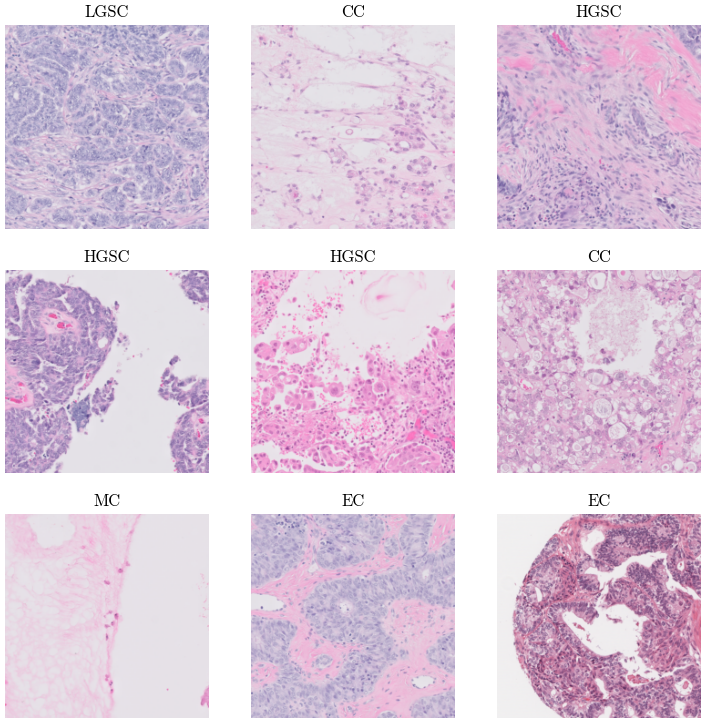

In [15]:
# how I did it with the snakes classifier

# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),  #input is an image, output is a category
#     get_items = get_image_files,   #returns a list of all images files path
#     splitter=RandomSplitter(valid_pct=0.2, seed=12),  # set size of validation set (randomly)
#     get_y = parent_label,   # how do we know the correct label?  This function returns the parent folder of the path
#     item_tfms=[Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)]  # most architectures need all images the same size
# ).dataloaders(path)   #dataloaders are what pytorch uses to feed the training algo.

dls.show_batch(max_n=9) # shows the input (picture) and the label


In [16]:
# learn = vision_learner(dls,resnet18,metrics=error_rate)
# learn.fine_tune(3)

In [17]:
# #learn.lr_find(suggest_funcs=(valley, slide))
# loss,acc = learn.validate()
learn.dls.vocab

['CC', 'EC', 'HGSC', 'LGSC', 'MC']

In [18]:
acc_val = np.array(acc_val)
acc_val

array([[0.86347884, 0.71025258],
       [0.95486534, 0.70579493],
       [0.99726623, 0.69494045],
       [0.99750638, 0.66964287]])

In [19]:
print(f'Mean acc is: {np.mean(acc_val[:,1]):.5f}, Mean Loss is {np.mean(acc_val[:,0]):.3f}, std is: {np.std(acc_val[:,1]):.5f}')

# mean .53883 with no scaling
# Mean is .44932 next run (.05 lr)...This verifies that randomness is greater for scores than scaling, but do another
# still lr =.05, mean is .48695
# again, .47521 (this just doesn't seem like a great optimized solution)
# try .01, .50498, looks like this set has worse images

Mean acc is: 0.69516, Mean Loss is 0.953, std is: 0.01575


In [20]:
# save so I can infer in the next notebook.  downloaded this file 11/14/23 3:38pm
learn.export(fname='5x1024_tma2x_convnext_5_epochs_04_lr.pkl')